In [1]:
%matplotlib inline
import netCDF4
import rasterio
import os
from datetime import datetime
import numpy as np
import spotpy
import matplotlib.pyplot as plt

In [2]:
# local libraries
from coupling_PCR_FM.model_functions_v2 import PCR_model, CMF_model, DFM_model
from coupling_PCR_FM.utils import config_to_dict, determineSteps
%config Application.log_level="INFO"

In [3]:
# IMPORT MODEL SETTINGS FROM INI-FILE
argv1 = r'default_rename.set'
argv2 = r'paths.env'

# parse set/ini-file with central/general settings for coupling framework
config = config_to_dict(argv1)
# parse env-file for user-specific paths and environmental variables
envs = config_to_dict(argv2)
# combine
config.update(envs)
options = config
# parse dates
start_date = datetime.strptime(options['numerical_settings']['startTime'], '%Y-%m-%d')
end_date = datetime.strptime(options['numerical_settings']['endTime'], '%Y-%m-%d')
print start_date
print end_date
timeSteps = determineSteps(start_date, end_date)
print timeSteps

2000-01-01 00:00:00
2001-12-31 00:00:00
730


In [4]:
# setup output dir
cwd = os.getcwd() # note: this get changed by pcr initialization later on
out_dir = options['PCRpaths']['outputDirectoryPCR']
out_dir = out_dir + 'PCR2CMF/'
if not os.path.isdir(out_dir):
    os.mkdir(out_dir)
print(out_dir)
print(cwd)

/home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2CMF/
/home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim


## create PCR model BMI object

Note that we use a two step initializiation. in the first step the bmi object is initialized and the model config file is read into memory. This config file can then be changed offline before the model is initialized. This allows for change model input files and setting based on the model coupling.

In [5]:
PCR_configfile = os.path.join(cwd, options['hydrologic_model']['config_dir'], options['hydrologic_model']['config_file'])
PCR_in_dir = options['PCRpaths']['inputDirectoryPCR']
PCR_out_dir = os.path.join(out_dir, 'PCR')

PCR_bmi = PCR_model(PCR_configfile, PCR_in_dir, PCR_out_dir,
                            start_date, end_date)


The illustrate the two-step initialization, the model config file is shown

In [6]:
PCR_bmi.model_config

OrderedDict([(u'globalOptions',
              OrderedDict([('inputDir',
                            u'/home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim/test_Elbe/PCR_Elbe/input30min'),
                           ('cloneMap', u'clone_elbe_30min.map'),
                           ('landmask', u'landmask_elbe_30min.map'),
                           ('outputDir',
                            u'/home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2CMF/PCR'),
                           ('institution',
                            u'Department of Physical Geography, Utrecht University'),
                           ('title', u'PCR-GLOBWB output'),
                           ('description',
                            u'test version by Edwin H. Sutanudjaja; adapted by J. Hoch'),
                           ('startTime', '2000-01-01'),
                           ('endTime', '2001-12-31'),
                           ('maxSpinUpsInYears', u'1'),
                           ('minConvForTotlSto', u'0.5'),
  

## create CMF model BMi object

In [7]:
CMF_engine = os.path.join(cwd, options['CMF_engine']['CMF_path'])
CMF_model_dir = os.path.join(cwd, options['routing_model']['model_dir'])
CMF_config_fn = os.path.join(CMF_model_dir, options['routing_model']['model_file'])
CMF_out_dir = os.path.join(out_dir, 'CMF')
     
CMF_bmi = CMF_model(CMF_engine, CMF_config_fn, CMF_model_dir, CMF_out_dir,
                         start_date, end_date)

## couple grids based on CMF inpmat file

In [8]:
# couple
PCR_bmi.couple_grid_to_grid(CMF_bmi)

## initialize models

In [9]:
# initialize model at CMF_out_dir after inpmat has been set in the grid_to_grid coupling function.
CMF_bmi.initialize()
# initialize model 
PCR_bmi.initialize()

INFO: configuration.initialize_logging(): Model run started at 2018-03-16 15:13:39.370664
2018-03-16 15:13:39,377 pcrglobwb_bmi_v203.configuration INFO Model run started at 2018-03-16 15:13:39.370664
INFO: configuration.initialize_logging(): Logging output to /home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2CMF/PCR/log/setup_PCR_30min_Elbe.ini_2018-03-16T15:13:39.370664.log
2018-03-16 15:13:39,379 pcrglobwb_bmi_v203.configuration INFO Logging output to /home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2CMF/PCR/log/setup_PCR_30min_Elbe.ini_2018-03-16T15:13:39.370664.log
INFO: configuration.repair_ini_key_names(): Note that avgSurfaceWaterInputLongIni is not used and not needed.
2018-03-16 15:13:39,380 pcrglobwb_bmi_v203.configuration INFO Note that avgSurfaceWaterInputLongIni is not used and not needed.
INFO: configuration.repair_ini_key_names(): The initial condition "subDischargeIni" is not defined. Either "avgDischargeShortIni" or "avgDischargeLongIni" is used in this run. No

## run coupled PCR - CMF model

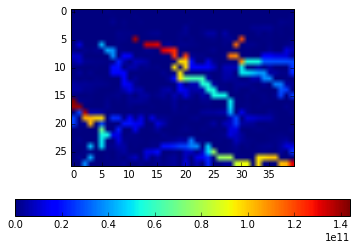

In [10]:
#- get upsteram area at comparison point in CMF
upArea = np.fromfile(r'/home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim/test_Elbe/CMF_Elbe/uparea.bin', 'f').reshape(28,40)
plt.imshow(upArea)
plt.colorbar(orientation='horizontal')

In [11]:
#- check whether upstream area at chosen location is at the upper end
#- upstream area according to GRDC: 131950 km2 = 1.31950e11 m2
xCMFout = 6
yCMFout = 13
print (upArea[xCMFout, yCMFout])

1.34112e+11


In [12]:
# create file for writing CMF output
cmf_outFile = os.path.join(CMF_out_dir, 'qsim_CFM_at_location_' + str(xCMFout) + '_' + str(yCMFout) + '.txt')
cmf_of = open(cmf_outFile, 'w')
print (cmf_of)

<open file u'/home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2CMF/CMF/qsim_CFM_at_location_6_13.txt', mode 'w' at 0x7f8988bf7540>


In [13]:
# run coupled model for 20 timesteps
def update_states():
    "coupling runoff between CMFan PCR model"
#     runoff = PCR_bmi.get_var('landSurfaceRunoff')
    runoff = PCR_bmi.get_var('runoff')
    runoff = np.where(np.isnan(runoff), 0, runoff)
    CMF_bmi.set_var("roffin", runoff)
        
tStart = datetime.now()
for i in range(timeSteps):
# for i in range(20):
    PCR_bmi.update()
    update_states()
    CMF_bmi.update()  
    outflw_temp = np.copy(CMF_bmi.get_var('outflw'))[xCMFout, yCMFout]
    cmf_of.write(str(outflw_temp) + os.linesep)
tEnd = datetime.now()
cmf_of.close()

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-01
2018-03-16 15:13:53,517 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-01
INFO: pcrglobwb.update(): updating model to time 2000-01-01
2018-03-16 15:13:53,787 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-01, timestep 1
2018-03-16 15:13:56,030 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-01, timestep 1
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-02 00:00:00, timestep 86400.0
2018-03-16 15:13:56,283 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-02 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-02
2018-03-16 15:13:56,285 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-02
INFO

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-11
2018-03-16 15:14:11,231 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-11
INFO: pcrglobwb.update(): updating model to time 2000-01-11
2018-03-16 15:14:11,597 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-11, timestep 11
2018-03-16 15:14:12,769 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-11, timestep 11
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-12 00:00:00, timestep 86400.0
2018-03-16 15:14:12,864 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-12 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-12
2018-03-16 15:14:12,867 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-12
IN

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-21
2018-03-16 15:14:27,697 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-21
INFO: pcrglobwb.update(): updating model to time 2000-01-21
2018-03-16 15:14:28,201 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-21, timestep 21
2018-03-16 15:14:29,321 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-21, timestep 21
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-22 00:00:00, timestep 86400.0
2018-03-16 15:14:29,361 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-22 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-22
2018-03-16 15:14:29,367 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-22
IN

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-31
2018-03-16 15:14:44,485 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-31
INFO: pcrglobwb.update(): updating model to time 2000-01-31
2018-03-16 15:14:44,901 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-31
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-31, timestep 31
2018-03-16 15:14:46,055 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-31, timestep 31
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-02-01 00:00:00, timestep 86400.0
2018-03-16 15:14:46,185 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-02-01 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-01
2018-03-16 15:14:46,189 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-01
IN

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-10
2018-03-16 15:15:01,233 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-10
INFO: pcrglobwb.update(): updating model to time 2000-02-10
2018-03-16 15:15:01,602 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-10, timestep 41
2018-03-16 15:15:02,755 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-10, timestep 41
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-02-11 00:00:00, timestep 86400.0
2018-03-16 15:15:02,817 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-02-11 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-11
2018-03-16 15:15:02,824 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-11
IN

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-20
2018-03-16 15:15:17,816 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-20
INFO: pcrglobwb.update(): updating model to time 2000-02-20
2018-03-16 15:15:18,298 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-20, timestep 51
2018-03-16 15:15:19,496 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-20, timestep 51
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-02-21 00:00:00, timestep 86400.0
2018-03-16 15:15:19,564 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-02-21 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-21
2018-03-16 15:15:19,569 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-21
IN

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-01
2018-03-16 15:15:34,404 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-01
INFO: pcrglobwb.update(): updating model to time 2000-03-01
2018-03-16 15:15:34,826 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-01, timestep 61
2018-03-16 15:15:36,311 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-01, timestep 61
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-03-02 00:00:00, timestep 86400.0
2018-03-16 15:15:36,361 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-03-02 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-02
2018-03-16 15:15:36,364 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-02
IN

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-11
2018-03-16 15:15:51,548 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-11
INFO: pcrglobwb.update(): updating model to time 2000-03-11
2018-03-16 15:15:51,968 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-11, timestep 71
2018-03-16 15:15:53,125 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-11, timestep 71
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-03-12 00:00:00, timestep 86400.0
2018-03-16 15:15:53,186 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-03-12 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-12
2018-03-16 15:15:53,189 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-12
IN

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-21
2018-03-16 15:16:08,097 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-21
INFO: pcrglobwb.update(): updating model to time 2000-03-21
2018-03-16 15:16:08,477 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-21, timestep 81
2018-03-16 15:16:09,697 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-21, timestep 81
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-03-22 00:00:00, timestep 86400.0
2018-03-16 15:16:09,763 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-03-22 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-22
2018-03-16 15:16:09,770 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-22
IN

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-31
2018-03-16 15:16:24,635 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-31
INFO: pcrglobwb.update(): updating model to time 2000-03-31
2018-03-16 15:16:25,041 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-31
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-31, timestep 91
2018-03-16 15:16:26,218 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-31, timestep 91
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-04-01 00:00:00, timestep 86400.0
2018-03-16 15:16:26,267 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-04-01 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-01
2018-03-16 15:16:26,273 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-01
IN

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-10
2018-03-16 15:16:41,712 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-10
INFO: pcrglobwb.update(): updating model to time 2000-04-10
2018-03-16 15:16:42,171 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-10, timestep 101
2018-03-16 15:16:43,344 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-10, timestep 101
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-04-11 00:00:00, timestep 86400.0
2018-03-16 15:16:43,440 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-04-11 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-11
2018-03-16 15:16:43,447 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-11


2018-03-16 15:16:58,338 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-04-20 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-20
2018-03-16 15:16:58,342 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-20
INFO: pcrglobwb.update(): updating model to time 2000-04-20
2018-03-16 15:16:58,768 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-20, timestep 111
2018-03-16 15:16:59,946 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-20, timestep 111
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-04-21 00:00:00, timestep 86400.0
2018-03-16 15:16:59,966 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-04-21 00:00:00, timestep 86400.0
INFO: pcrg

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-04-30 00:00:00, timestep 86400.0
2018-03-16 15:17:15,146 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-04-30 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-30
2018-03-16 15:17:15,149 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-30
INFO: pcrglobwb.update(): updating model to time 2000-04-30
2018-03-16 15:17:15,592 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-30, timestep 121
2018-03-16 15:17:16,758 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-30, timestep 121
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-05-01 00:00:00, timestep 86400.0
2018-03-16 15:17:16,876 coupling_PCR_FM

2018-03-16 15:17:31,941 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-09, timestep 130
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-05-10 00:00:00, timestep 86400.0
2018-03-16 15:17:32,289 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-05-10 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-10
2018-03-16 15:17:32,293 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-10
INFO: pcrglobwb.update(): updating model to time 2000-05-10
2018-03-16 15:17:32,699 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-10, timestep 131
2018-03-16 15:17:33,888 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-10, timestep 131
INFO: model_functions_v2.update(

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-19, timestep 140
2018-03-16 15:17:48,694 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-19, timestep 140
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-05-20 00:00:00, timestep 86400.0
2018-03-16 15:17:48,750 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-05-20 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-20
2018-03-16 15:17:48,753 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-20
INFO: pcrglobwb.update(): updating model to time 2000-05-20
2018-03-16 15:17:49,164 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-20, timestep 141
2018-03-16 15:17:50,391 coupling_PCR_FM.model_functions_v2 IN

INFO: pcrglobwb.update(): updating model to time 2000-05-29
2018-03-16 15:18:04,119 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-29, timestep 150
2018-03-16 15:18:05,279 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-29, timestep 150
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-05-30 00:00:00, timestep 86400.0
2018-03-16 15:18:05,318 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-05-30 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-30
2018-03-16 15:18:05,321 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-30
INFO: pcrglobwb.update(): updating model to time 2000-05-30
2018-03-16 15:18:05,751 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-30
INFO: model_f

2018-03-16 15:18:20,191 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-08
INFO: pcrglobwb.update(): updating model to time 2000-06-08
2018-03-16 15:18:20,563 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-08
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-08, timestep 160
2018-03-16 15:18:21,773 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-08, timestep 160
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-06-09 00:00:00, timestep 86400.0
2018-03-16 15:18:21,809 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-06-09 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-09
2018-03-16 15:18:21,817 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-09
INFO: pcrglobwb.update(): updating model to time 2000-06-09
2018-03-16

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-18
2018-03-16 15:18:36,822 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-18
INFO: pcrglobwb.update(): updating model to time 2000-06-18
2018-03-16 15:18:37,171 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-18, timestep 170
2018-03-16 15:18:38,351 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-18, timestep 170
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-06-19 00:00:00, timestep 86400.0
2018-03-16 15:18:38,421 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-06-19 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-19
2018-03-16 15:18:38,423 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-19


2018-03-16 15:18:53,252 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-06-28 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-28
2018-03-16 15:18:53,255 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-28
INFO: pcrglobwb.update(): updating model to time 2000-06-28
2018-03-16 15:18:53,576 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-28, timestep 180
2018-03-16 15:18:54,778 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-28, timestep 180
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-06-29 00:00:00, timestep 86400.0
2018-03-16 15:18:54,839 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-06-29 00:00:00, timestep 86400.0
INFO: pcrg

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-07-08 00:00:00, timestep 86400.0
2018-03-16 15:19:10,478 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-07-08 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-08
2018-03-16 15:19:10,489 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-08
INFO: pcrglobwb.update(): updating model to time 2000-07-08
2018-03-16 15:19:10,860 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-08
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-08, timestep 190
2018-03-16 15:19:12,018 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-08, timestep 190
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-07-09 00:00:00, timestep 86400.0
2018-03-16 15:19:12,081 coupling_PCR_FM

2018-03-16 15:19:26,655 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-17, timestep 199
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-07-18 00:00:00, timestep 86400.0
2018-03-16 15:19:26,971 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-07-18 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-18
2018-03-16 15:19:26,973 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-18
INFO: pcrglobwb.update(): updating model to time 2000-07-18
2018-03-16 15:19:27,411 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-18, timestep 200
2018-03-16 15:19:28,583 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-18, timestep 200
INFO: model_functions_v2.update(

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-27, timestep 209
2018-03-16 15:19:43,500 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-27, timestep 209
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-07-28 00:00:00, timestep 86400.0
2018-03-16 15:19:43,564 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-07-28 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-28
2018-03-16 15:19:43,566 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-28
INFO: pcrglobwb.update(): updating model to time 2000-07-28
2018-03-16 15:19:43,984 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-28, timestep 210
2018-03-16 15:19:45,167 coupling_PCR_FM.model_functions_v2 IN

INFO: pcrglobwb.update(): updating model to time 2000-08-06
2018-03-16 15:19:59,540 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-06, timestep 219
2018-03-16 15:20:00,725 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-06, timestep 219
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-08-07 00:00:00, timestep 86400.0
2018-03-16 15:20:00,761 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-08-07 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-07
2018-03-16 15:20:00,763 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-07
INFO: pcrglobwb.update(): updating model to time 2000-08-07
2018-03-16 15:20:01,103 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-07
INFO: model_f

2018-03-16 15:20:17,179 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-16
INFO: pcrglobwb.update(): updating model to time 2000-08-16
2018-03-16 15:20:17,580 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-16
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-16, timestep 229
2018-03-16 15:20:18,771 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-16, timestep 229
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-08-17 00:00:00, timestep 86400.0
2018-03-16 15:20:18,840 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-08-17 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-17
2018-03-16 15:20:18,843 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-17
INFO: pcrglobwb.update(): updating model to time 2000-08-17
2018-03-16

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-26
2018-03-16 15:20:34,227 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-26
INFO: pcrglobwb.update(): updating model to time 2000-08-26
2018-03-16 15:20:34,600 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-26, timestep 239
2018-03-16 15:20:35,777 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-26, timestep 239
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-08-27 00:00:00, timestep 86400.0
2018-03-16 15:20:35,852 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-08-27 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-27
2018-03-16 15:20:35,858 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-27


2018-03-16 15:20:51,294 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-09-05 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-05
2018-03-16 15:20:51,296 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-05
INFO: pcrglobwb.update(): updating model to time 2000-09-05
2018-03-16 15:20:51,784 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-05, timestep 249
2018-03-16 15:20:52,957 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-05, timestep 249
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-09-06 00:00:00, timestep 86400.0
2018-03-16 15:20:53,026 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-09-06 00:00:00, timestep 86400.0
INFO: pcrg

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-09-15 00:00:00, timestep 86400.0
2018-03-16 15:21:08,528 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-09-15 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-15
2018-03-16 15:21:08,533 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-15
INFO: pcrglobwb.update(): updating model to time 2000-09-15
2018-03-16 15:21:09,011 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-15, timestep 259
2018-03-16 15:21:10,211 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-15, timestep 259
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-09-16 00:00:00, timestep 86400.0
2018-03-16 15:21:10,346 coupling_PCR_FM

2018-03-16 15:21:25,351 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-24, timestep 268
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-09-25 00:00:00, timestep 86400.0
2018-03-16 15:21:25,420 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-09-25 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-25
2018-03-16 15:21:25,425 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-25
INFO: pcrglobwb.update(): updating model to time 2000-09-25
2018-03-16 15:21:25,891 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-25, timestep 269
2018-03-16 15:21:27,201 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-25, timestep 269
INFO: model_functions_v2.update(

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-04, timestep 278
2018-03-16 15:21:42,463 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-04, timestep 278
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-10-05 00:00:00, timestep 86400.0
2018-03-16 15:21:42,552 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-10-05 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-05
2018-03-16 15:21:42,555 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-05
INFO: pcrglobwb.update(): updating model to time 2000-10-05
2018-03-16 15:21:42,918 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-05, timestep 279
2018-03-16 15:21:44,140 coupling_PCR_FM.model_functions_v2 IN

INFO: pcrglobwb.update(): updating model to time 2000-10-14
2018-03-16 15:21:58,055 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-14, timestep 288
2018-03-16 15:21:59,230 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-14, timestep 288
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-10-15 00:00:00, timestep 86400.0
2018-03-16 15:21:59,358 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-10-15 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-15
2018-03-16 15:21:59,366 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-15
INFO: pcrglobwb.update(): updating model to time 2000-10-15
2018-03-16 15:21:59,719 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-15
INFO: model_f

2018-03-16 15:22:14,618 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-24
INFO: pcrglobwb.update(): updating model to time 2000-10-24
2018-03-16 15:22:14,957 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-24
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-24, timestep 298
2018-03-16 15:22:16,147 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-24, timestep 298
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-10-25 00:00:00, timestep 86400.0
2018-03-16 15:22:16,186 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-10-25 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-25
2018-03-16 15:22:16,191 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-25
INFO: pcrglobwb.update(): updating model to time 2000-10-25
2018-03-16

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-03
2018-03-16 15:22:31,886 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-03
INFO: pcrglobwb.update(): updating model to time 2000-11-03
2018-03-16 15:22:32,311 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-03, timestep 308
2018-03-16 15:22:33,543 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-03, timestep 308
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-11-04 00:00:00, timestep 86400.0
2018-03-16 15:22:33,586 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-11-04 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-04
2018-03-16 15:22:33,589 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-04


2018-03-16 15:22:48,371 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-11-13 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-13
2018-03-16 15:22:48,374 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-13
INFO: pcrglobwb.update(): updating model to time 2000-11-13
2018-03-16 15:22:48,866 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-13, timestep 318
2018-03-16 15:22:50,039 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-13, timestep 318
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-11-14 00:00:00, timestep 86400.0
2018-03-16 15:22:50,072 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-11-14 00:00:00, timestep 86400.0
INFO: pcrg

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-11-23 00:00:00, timestep 86400.0
2018-03-16 15:23:05,704 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-11-23 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-23
2018-03-16 15:23:05,706 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-23
INFO: pcrglobwb.update(): updating model to time 2000-11-23
2018-03-16 15:23:06,111 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-23
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-23, timestep 328
2018-03-16 15:23:07,373 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-23, timestep 328
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-11-24 00:00:00, timestep 86400.0
2018-03-16 15:23:07,481 coupling_PCR_FM

2018-03-16 15:23:22,544 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-02, timestep 337
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-12-03 00:00:00, timestep 86400.0
2018-03-16 15:23:22,610 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-12-03 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-03
2018-03-16 15:23:22,616 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-03
INFO: pcrglobwb.update(): updating model to time 2000-12-03
2018-03-16 15:23:23,045 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-03, timestep 338
2018-03-16 15:23:24,221 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-03, timestep 338
INFO: model_functions_v2.update(

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-12, timestep 347
2018-03-16 15:23:39,150 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-12, timestep 347
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-12-13 00:00:00, timestep 86400.0
2018-03-16 15:23:39,196 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-12-13 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-13
2018-03-16 15:23:39,202 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-13
INFO: pcrglobwb.update(): updating model to time 2000-12-13
2018-03-16 15:23:39,698 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-13, timestep 348
2018-03-16 15:23:40,931 coupling_PCR_FM.model_functions_v2 IN

INFO: pcrglobwb.update(): updating model to time 2000-12-22
2018-03-16 15:23:54,915 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-22, timestep 357
2018-03-16 15:23:56,153 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-22, timestep 357
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-12-23 00:00:00, timestep 86400.0
2018-03-16 15:23:56,191 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-12-23 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-23
2018-03-16 15:23:56,193 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-23
INFO: pcrglobwb.update(): updating model to time 2000-12-23
2018-03-16 15:23:56,506 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-23
INFO: model_f

INFO: pcrglobwb.report(): Accumulated precipitation days 1 to 366 in 2000 = 9.355974e+01 km3 = 6.273453e+02 mm
2018-03-16 15:24:11,377 model INFO Accumulated precipitation days 1 to 366 in 2000 = 9.355974e+01 km3 = 6.273453e+02 mm
INFO: pcrglobwb.report(): Accumulated nonFossilGroundwaterAbs days 1 to 366 in 2000 = 9.021893e+00 km3 = 6.049442e+01 mm
2018-03-16 15:24:11,381 model INFO Accumulated nonFossilGroundwaterAbs days 1 to 366 in 2000 = 9.021893e+00 km3 = 6.049442e+01 mm
INFO: pcrglobwb.report(): Accumulated allocNonFossilGroundwater days 1 to 366 in 2000 = 9.021893e+00 km3 = 6.049442e+01 mm
2018-03-16 15:24:11,385 model INFO Accumulated allocNonFossilGroundwater days 1 to 366 in 2000 = 9.021893e+00 km3 = 6.049442e+01 mm
INFO: pcrglobwb.report(): Accumulated baseflow days 1 to 366 in 2000 = 1.965035e+01 km3 = 1.317613e+02 mm
2018-03-16 15:24:11,389 model INFO Accumulated baseflow days 1 to 366 in 2000 = 1.965035e+01 km3 = 1.317613e+02 mm
INFO: pcrglobwb.report(): Accumulated surf

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-31, timestep 366
2018-03-16 15:24:11,442 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-31, timestep 366
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-01-01 00:00:00, timestep 86400.0
2018-03-16 15:24:11,530 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-01-01 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-01-01
2018-03-16 15:24:11,533 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-01-01
INFO: pcrglobwb.update(): updating model to time 2001-01-01
2018-03-16 15:24:11,982 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-01-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-01-01, timestep 367
2018-03-16 15:24:14,368 coupling_PCR_FM.model_functions_v2 IN

INFO: pcrglobwb.update(): updating model to time 2001-01-10
2018-03-16 15:24:28,563 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-01-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-01-10, timestep 376
2018-03-16 15:24:29,790 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-01-10, timestep 376
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-01-11 00:00:00, timestep 86400.0
2018-03-16 15:24:29,847 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-01-11 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-01-11
2018-03-16 15:24:29,855 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-01-11
INFO: pcrglobwb.update(): updating model to time 2001-01-11
2018-03-16 15:24:30,245 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-01-11
INFO: model_f

2018-03-16 15:24:45,400 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-01-20
INFO: pcrglobwb.update(): updating model to time 2001-01-20
2018-03-16 15:24:45,772 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-01-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-01-20, timestep 386
2018-03-16 15:24:46,999 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-01-20, timestep 386
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-01-21 00:00:00, timestep 86400.0
2018-03-16 15:24:47,047 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-01-21 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-01-21
2018-03-16 15:24:47,050 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-01-21
INFO: pcrglobwb.update(): updating model to time 2001-01-21
2018-03-16

INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-01-30
2018-03-16 15:25:01,745 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-01-30
INFO: pcrglobwb.update(): updating model to time 2001-01-30
2018-03-16 15:25:02,200 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-01-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-01-30, timestep 396
2018-03-16 15:25:03,442 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-01-30, timestep 396
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-01-31 00:00:00, timestep 86400.0
2018-03-16 15:25:03,485 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-01-31 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-01-31
2018-03-16 15:25:03,490 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-01-31


2018-03-16 15:25:18,953 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-02-09 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-02-09
2018-03-16 15:25:18,959 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-02-09
INFO: pcrglobwb.update(): updating model to time 2001-02-09
2018-03-16 15:25:19,450 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-02-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-02-09, timestep 406
2018-03-16 15:25:20,684 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-02-09, timestep 406
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-02-10 00:00:00, timestep 86400.0
2018-03-16 15:25:20,781 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-02-10 00:00:00, timestep 86400.0
INFO: pcrg

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-02-19 00:00:00, timestep 86400.0
2018-03-16 15:25:36,147 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-02-19 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-02-19
2018-03-16 15:25:36,151 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-02-19
INFO: pcrglobwb.update(): updating model to time 2001-02-19
2018-03-16 15:25:36,648 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-02-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-02-19, timestep 416
2018-03-16 15:25:37,859 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-02-19, timestep 416
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-02-20 00:00:00, timestep 86400.0
2018-03-16 15:25:37,937 coupling_PCR_FM

2018-03-16 15:25:52,853 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-02-28, timestep 425
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-03-01 00:00:00, timestep 86400.0
2018-03-16 15:25:52,921 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-03-01 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-03-01
2018-03-16 15:25:52,928 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-03-01
INFO: pcrglobwb.update(): updating model to time 2001-03-01
2018-03-16 15:25:53,294 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-03-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-03-01, timestep 426
2018-03-16 15:25:54,764 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-03-01, timestep 426
INFO: model_functions_v2.update(

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-03-10, timestep 435
2018-03-16 15:26:10,278 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-03-10, timestep 435
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-03-11 00:00:00, timestep 86400.0
2018-03-16 15:26:10,488 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-03-11 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-03-11
2018-03-16 15:26:10,494 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-03-11
INFO: pcrglobwb.update(): updating model to time 2001-03-11
2018-03-16 15:26:10,948 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-03-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-03-11, timestep 436
2018-03-16 15:26:12,138 coupling_PCR_FM.model_functions_v2 IN

INFO: pcrglobwb.update(): updating model to time 2001-03-20
2018-03-16 15:26:25,973 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-03-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-03-20, timestep 445
2018-03-16 15:26:27,142 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-03-20, timestep 445
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-03-21 00:00:00, timestep 86400.0
2018-03-16 15:26:27,216 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-03-21 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-03-21
2018-03-16 15:26:27,220 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-03-21
INFO: pcrglobwb.update(): updating model to time 2001-03-21
2018-03-16 15:26:27,664 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-03-21
INFO: model_f

2018-03-16 15:26:42,817 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-03-30
INFO: pcrglobwb.update(): updating model to time 2001-03-30
2018-03-16 15:26:43,200 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-03-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-03-30, timestep 455
2018-03-16 15:26:44,388 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-03-30, timestep 455
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-03-31 00:00:00, timestep 86400.0
2018-03-16 15:26:44,467 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-03-31 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-03-31
2018-03-16 15:26:44,475 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-03-31
INFO: pcrglobwb.update(): updating model to time 2001-03-31
2018-03-16

INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-04-09
2018-03-16 15:26:59,922 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-04-09
INFO: pcrglobwb.update(): updating model to time 2001-04-09
2018-03-16 15:27:00,393 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-04-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-04-09, timestep 465
2018-03-16 15:27:01,584 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-04-09, timestep 465
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-04-10 00:00:00, timestep 86400.0
2018-03-16 15:27:01,636 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-04-10 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-04-10
2018-03-16 15:27:01,641 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-04-10


2018-03-16 15:27:16,803 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-04-19 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-04-19
2018-03-16 15:27:16,809 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-04-19
INFO: pcrglobwb.update(): updating model to time 2001-04-19
2018-03-16 15:27:17,238 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-04-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-04-19, timestep 475
2018-03-16 15:27:18,484 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-04-19, timestep 475
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-04-20 00:00:00, timestep 86400.0
2018-03-16 15:27:18,531 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-04-20 00:00:00, timestep 86400.0
INFO: pcrg

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-04-29 00:00:00, timestep 86400.0
2018-03-16 15:27:34,516 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-04-29 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-04-29
2018-03-16 15:27:34,522 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-04-29
INFO: pcrglobwb.update(): updating model to time 2001-04-29
2018-03-16 15:27:34,928 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-04-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-04-29, timestep 485
2018-03-16 15:27:36,141 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-04-29, timestep 485
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-04-30 00:00:00, timestep 86400.0
2018-03-16 15:27:36,188 coupling_PCR_FM

2018-03-16 15:27:51,787 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-05-08, timestep 494
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-05-09 00:00:00, timestep 86400.0
2018-03-16 15:27:52,041 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-05-09 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-05-09
2018-03-16 15:27:52,043 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-05-09
INFO: pcrglobwb.update(): updating model to time 2001-05-09
2018-03-16 15:27:52,501 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-05-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-05-09, timestep 495
2018-03-16 15:27:53,722 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-05-09, timestep 495
INFO: model_functions_v2.update(

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-05-18, timestep 504
2018-03-16 15:28:09,642 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-05-18, timestep 504
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-05-19 00:00:00, timestep 86400.0
2018-03-16 15:28:09,699 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-05-19 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-05-19
2018-03-16 15:28:09,704 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-05-19
INFO: pcrglobwb.update(): updating model to time 2001-05-19
2018-03-16 15:28:10,093 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-05-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-05-19, timestep 505
2018-03-16 15:28:11,223 coupling_PCR_FM.model_functions_v2 IN

INFO: pcrglobwb.update(): updating model to time 2001-05-28
2018-03-16 15:28:25,526 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-05-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-05-28, timestep 514
2018-03-16 15:28:26,772 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-05-28, timestep 514
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-05-29 00:00:00, timestep 86400.0
2018-03-16 15:28:26,833 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-05-29 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-05-29
2018-03-16 15:28:26,838 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-05-29
INFO: pcrglobwb.update(): updating model to time 2001-05-29
2018-03-16 15:28:27,312 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-05-29
INFO: model_f

2018-03-16 15:28:42,279 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-06-07
INFO: pcrglobwb.update(): updating model to time 2001-06-07
2018-03-16 15:28:42,770 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-06-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-06-07, timestep 524
2018-03-16 15:28:44,023 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-06-07, timestep 524
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-06-08 00:00:00, timestep 86400.0
2018-03-16 15:28:44,255 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-06-08 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-06-08
2018-03-16 15:28:44,261 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-06-08
INFO: pcrglobwb.update(): updating model to time 2001-06-08
2018-03-16

INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-06-17
2018-03-16 15:28:59,164 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-06-17
INFO: pcrglobwb.update(): updating model to time 2001-06-17
2018-03-16 15:28:59,581 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-06-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-06-17, timestep 534
2018-03-16 15:29:00,764 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-06-17, timestep 534
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-06-18 00:00:00, timestep 86400.0
2018-03-16 15:29:00,845 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-06-18 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-06-18
2018-03-16 15:29:00,849 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-06-18


2018-03-16 15:29:16,456 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-06-27 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-06-27
2018-03-16 15:29:16,462 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-06-27
INFO: pcrglobwb.update(): updating model to time 2001-06-27
2018-03-16 15:29:16,870 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-06-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-06-27, timestep 544
2018-03-16 15:29:18,070 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-06-27, timestep 544
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-06-28 00:00:00, timestep 86400.0
2018-03-16 15:29:18,140 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-06-28 00:00:00, timestep 86400.0
INFO: pcrg

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-07-07 00:00:00, timestep 86400.0
2018-03-16 15:29:33,478 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-07-07 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-07-07
2018-03-16 15:29:33,480 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-07-07
INFO: pcrglobwb.update(): updating model to time 2001-07-07
2018-03-16 15:29:33,861 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-07-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-07-07, timestep 554
2018-03-16 15:29:35,046 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-07-07, timestep 554
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-07-08 00:00:00, timestep 86400.0
2018-03-16 15:29:35,112 coupling_PCR_FM

2018-03-16 15:29:50,569 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-07-16, timestep 563
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-07-17 00:00:00, timestep 86400.0
2018-03-16 15:29:50,641 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-07-17 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-07-17
2018-03-16 15:29:50,644 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-07-17
INFO: pcrglobwb.update(): updating model to time 2001-07-17
2018-03-16 15:29:50,948 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-07-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-07-17, timestep 564
2018-03-16 15:29:52,113 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-07-17, timestep 564
INFO: model_functions_v2.update(

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-07-26, timestep 573
2018-03-16 15:30:07,759 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-07-26, timestep 573
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-07-27 00:00:00, timestep 86400.0
2018-03-16 15:30:08,033 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-07-27 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-07-27
2018-03-16 15:30:08,036 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-07-27
INFO: pcrglobwb.update(): updating model to time 2001-07-27
2018-03-16 15:30:08,480 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-07-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-07-27, timestep 574
2018-03-16 15:30:09,714 coupling_PCR_FM.model_functions_v2 IN

INFO: pcrglobwb.update(): updating model to time 2001-08-05
2018-03-16 15:30:24,581 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-08-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-08-05, timestep 583
2018-03-16 15:30:25,768 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-08-05, timestep 583
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-08-06 00:00:00, timestep 86400.0
2018-03-16 15:30:25,821 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-08-06 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-08-06
2018-03-16 15:30:25,829 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-08-06
INFO: pcrglobwb.update(): updating model to time 2001-08-06
2018-03-16 15:30:26,169 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-08-06
INFO: model_f

2018-03-16 15:30:41,439 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-08-15
INFO: pcrglobwb.update(): updating model to time 2001-08-15
2018-03-16 15:30:41,768 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-08-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-08-15, timestep 593
2018-03-16 15:30:42,993 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-08-15, timestep 593
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-08-16 00:00:00, timestep 86400.0
2018-03-16 15:30:43,012 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-08-16 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-08-16
2018-03-16 15:30:43,014 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-08-16
INFO: pcrglobwb.update(): updating model to time 2001-08-16
2018-03-16

INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-08-25
2018-03-16 15:30:58,725 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-08-25
INFO: pcrglobwb.update(): updating model to time 2001-08-25
2018-03-16 15:30:59,232 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-08-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-08-25, timestep 603
2018-03-16 15:31:00,479 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-08-25, timestep 603
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-08-26 00:00:00, timestep 86400.0
2018-03-16 15:31:00,542 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-08-26 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-08-26
2018-03-16 15:31:00,545 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-08-26


2018-03-16 15:31:15,885 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-09-04 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-09-04
2018-03-16 15:31:15,890 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-09-04
INFO: pcrglobwb.update(): updating model to time 2001-09-04
2018-03-16 15:31:16,228 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-09-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-09-04, timestep 613
2018-03-16 15:31:17,380 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-09-04, timestep 613
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-09-05 00:00:00, timestep 86400.0
2018-03-16 15:31:17,426 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-09-05 00:00:00, timestep 86400.0
INFO: pcrg

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-09-14 00:00:00, timestep 86400.0
2018-03-16 15:31:33,132 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-09-14 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-09-14
2018-03-16 15:31:33,135 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-09-14
INFO: pcrglobwb.update(): updating model to time 2001-09-14
2018-03-16 15:31:33,632 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-09-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-09-14, timestep 623
2018-03-16 15:31:34,822 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-09-14, timestep 623
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-09-15 00:00:00, timestep 86400.0
2018-03-16 15:31:34,914 coupling_PCR_FM

2018-03-16 15:31:50,486 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-09-23, timestep 632
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-09-24 00:00:00, timestep 86400.0
2018-03-16 15:31:50,564 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-09-24 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-09-24
2018-03-16 15:31:50,567 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-09-24
INFO: pcrglobwb.update(): updating model to time 2001-09-24
2018-03-16 15:31:51,017 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-09-24
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-09-24, timestep 633
2018-03-16 15:31:52,224 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-09-24, timestep 633
INFO: model_functions_v2.update(

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-10-03, timestep 642
2018-03-16 15:32:08,062 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-10-03, timestep 642
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-10-04 00:00:00, timestep 86400.0
2018-03-16 15:32:08,141 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-10-04 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-10-04
2018-03-16 15:32:08,145 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-10-04
INFO: pcrglobwb.update(): updating model to time 2001-10-04
2018-03-16 15:32:08,656 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-10-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-10-04, timestep 643
2018-03-16 15:32:09,899 coupling_PCR_FM.model_functions_v2 IN

INFO: pcrglobwb.update(): updating model to time 2001-10-13
2018-03-16 15:32:23,699 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-10-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-10-13, timestep 652
2018-03-16 15:32:24,884 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-10-13, timestep 652
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-10-14 00:00:00, timestep 86400.0
2018-03-16 15:32:24,935 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-10-14 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-10-14
2018-03-16 15:32:24,938 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-10-14
INFO: pcrglobwb.update(): updating model to time 2001-10-14
2018-03-16 15:32:25,306 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-10-14
INFO: model_f

2018-03-16 15:32:41,072 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-10-23
INFO: pcrglobwb.update(): updating model to time 2001-10-23
2018-03-16 15:32:41,503 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-10-23
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-10-23, timestep 662
2018-03-16 15:32:42,716 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-10-23, timestep 662
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-10-24 00:00:00, timestep 86400.0
2018-03-16 15:32:42,744 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-10-24 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-10-24
2018-03-16 15:32:42,746 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-10-24
INFO: pcrglobwb.update(): updating model to time 2001-10-24
2018-03-16

INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-11-02
2018-03-16 15:32:58,597 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-11-02
INFO: pcrglobwb.update(): updating model to time 2001-11-02
2018-03-16 15:32:59,053 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-11-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-11-02, timestep 672
2018-03-16 15:33:00,273 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-11-02, timestep 672
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-11-03 00:00:00, timestep 86400.0
2018-03-16 15:33:00,328 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-11-03 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-11-03
2018-03-16 15:33:00,334 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-11-03


2018-03-16 15:33:16,219 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-11-12 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-11-12
2018-03-16 15:33:16,224 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-11-12
INFO: pcrglobwb.update(): updating model to time 2001-11-12
2018-03-16 15:33:16,644 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-11-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-11-12, timestep 682
2018-03-16 15:33:17,844 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-11-12, timestep 682
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-11-13 00:00:00, timestep 86400.0
2018-03-16 15:33:17,911 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-11-13 00:00:00, timestep 86400.0
INFO: pcrg

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-11-22 00:00:00, timestep 86400.0
2018-03-16 15:33:33,449 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-11-22 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-11-22
2018-03-16 15:33:33,452 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-11-22
INFO: pcrglobwb.update(): updating model to time 2001-11-22
2018-03-16 15:33:33,865 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-11-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-11-22, timestep 692
2018-03-16 15:33:35,107 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-11-22, timestep 692
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-11-23 00:00:00, timestep 86400.0
2018-03-16 15:33:35,176 coupling_PCR_FM

2018-03-16 15:33:51,231 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-12-01, timestep 701
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-12-02 00:00:00, timestep 86400.0
2018-03-16 15:33:51,279 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-12-02 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-12-02
2018-03-16 15:33:51,281 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-12-02
INFO: pcrglobwb.update(): updating model to time 2001-12-02
2018-03-16 15:33:51,682 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-12-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-12-02, timestep 702
2018-03-16 15:33:52,963 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-12-02, timestep 702
INFO: model_functions_v2.update(

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-12-11, timestep 711
2018-03-16 15:34:08,726 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-12-11, timestep 711
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-12-12 00:00:00, timestep 86400.0
2018-03-16 15:34:08,810 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-12-12 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-12-12
2018-03-16 15:34:08,817 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-12-12
INFO: pcrglobwb.update(): updating model to time 2001-12-12
2018-03-16 15:34:09,264 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-12-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-12-12, timestep 712
2018-03-16 15:34:10,487 coupling_PCR_FM.model_functions_v2 IN

INFO: pcrglobwb.update(): updating model to time 2001-12-21
2018-03-16 15:34:24,403 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-12-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-12-21, timestep 721
2018-03-16 15:34:25,623 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-12-21, timestep 721
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-12-22 00:00:00, timestep 86400.0
2018-03-16 15:34:25,866 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-12-22 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-12-22
2018-03-16 15:34:25,870 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-12-22
INFO: pcrglobwb.update(): updating model to time 2001-12-22
2018-03-16 15:34:26,359 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-12-22
INFO: model_f

In [14]:
print 'start time coupling: ', tStart
print 'end time coupling: ', tEnd
print 'average time per update PCR->CMF->DFM: ', abs((tEnd - tStart)) / timeSteps

start time coupling:  2018-03-16 15:13:53.516602
end time coupling:  2018-03-16 15:34:41.365614
average time per update PCR->CMF->DFM:  0:00:01.709382


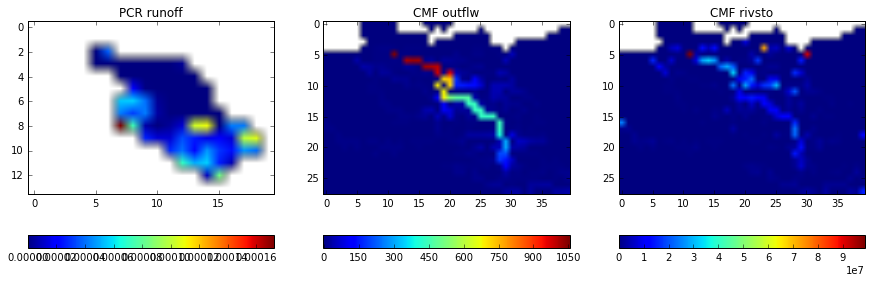

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

# PCR_bmi.update()
# routingModel.update_states()
# routingModel.update() 

runoff = PCR_bmi.get_var('landSurfaceRunoff')
outflw = CMF_bmi.get_var('outflw')
outflw = np.ma.masked_greater(outflw, 1.e19)
rivsto = CMF_bmi.get_var('rivsto_out')
rivsto = np.ma.masked_greater(rivsto, 1.e19)

fig = plt.figure(figsize=(15, 5))
a=fig.add_subplot(1,3,1)
imgplot = plt.imshow(runoff)
a.set_title('PCR runoff')
plt.colorbar(orientation ='horizontal')
a=fig.add_subplot(1,3,2)
imgplot = plt.imshow(outflw)
a.set_title('CMF outflw')
plt.colorbar(orientation='horizontal')
a=fig.add_subplot(1,3,3)
imgplot = plt.imshow(rivsto)
a.set_title('CMF rivsto')
plt.colorbar(orientation='horizontal')

In [16]:
# finalize model
PCR_bmi.finalize()

# finalize model
CMF_bmi.finalize()

INFO: wrapper.finalize(): cd /home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim
2018-03-16 15:34:42,320 bmi.wrapper INFO cd /home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim


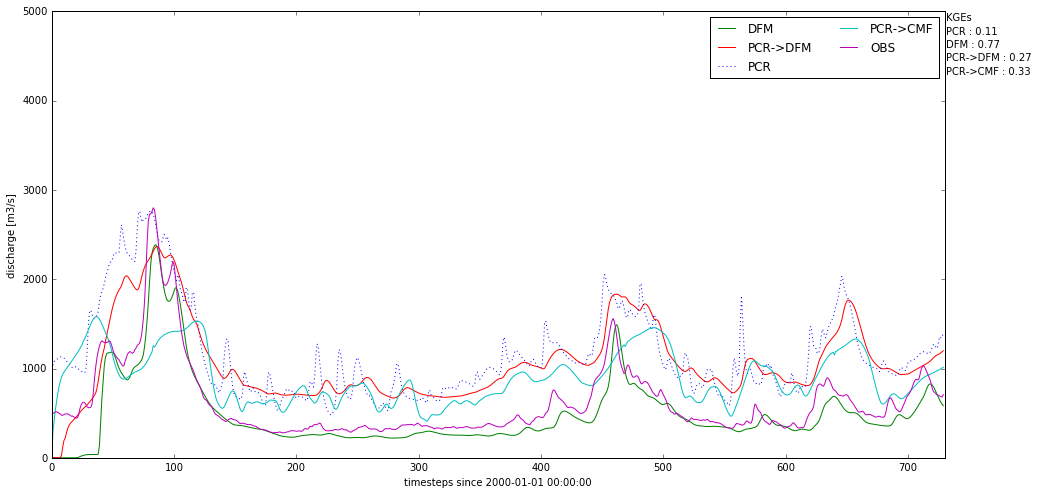

In [17]:
import matplotlib.dates as mdates
from netCDF4 import Dataset

#- laod DFM output file (from 1way coupled PCR->DFM run)
fo_1way = os.path.join(cwd, 'test_Elbe/', 'DFM_Elbe_VU_1way_his.nc')
#- laod DFM output file (from DFM stand alone)
fo_stA = os.path.join(cwd, 'test_Elbe/', 'DFM_Elbe_VU_standAlone_his.nc')
#- load BfG file
vo = os.path.join(cwd, 'test_Elbe/', 'Elbe-W+Q.csv')
#- load PCR file
po = os.path.join(cwd, 'test_Elbe/', 'Qsim_Elbe_Darchau_30min_2000s_industrial_prefactored.dump')

#- extract BfG data for NeuDarchau
vd = np.loadtxt(vo, unpack=True, converters = {0: mdates.strpdate2num('%d-%m-%y')}, delimiter=';', skiprows=4)
qobs_ND = vd[1]

#- estract PCR data
pd = np.loadtxt(po, unpack=True, skiprows=4)
PCR_ND = pd[1]
PCR_ND = PCR_ND[:]

#- extrat CMF data
cd = np.loadtxt(cmf_outFile, unpack=True)

#- extract simulated discharge from nc-file for 1way PCR->DFM
no_1way = Dataset(fo_1way, 'r')
qsim_1way = no_1way.variables['cross_section_discharge'][:]
#- split up to different cross-sectiosn
qsim_upBC_1way = np.absolute(qsim_1way[:,2])
qsim_ND_1way = np.absolute(qsim_1way[:,0])
qsim_downBC_1way = np.absolute(qsim_1way[:,1])

#- extract simulated discharge from nc-file for DFM standalone
no_stA = Dataset(fo_stA, 'r')
qsim_stA = no_stA.variables['cross_section_discharge'][:]
#- split up to different cross-sectiosn
qsim_upBC_stA = np.absolute(qsim_stA[:,2])
qsim_ND_stA = np.absolute(qsim_stA[:,0])
qsim_downBC_stA = np.absolute(qsim_stA[:,1])

#- limit to list with least entries
minLength = min(len(qsim_ND_1way), len(qsim_ND_stA), len(PCR_ND), len(cd))
if len(qobs_ND) > len(cd):
    qobs_ND = qobs_ND[:minLength]
    PCR_ND = PCR_ND[:minLength]
    qsim_ND_1way = qsim_ND_1way[:minLength]
    qsim_ND_stA = qsim_ND_stA[:minLength]
    cd = cd[:minLength]

#- computed KGE at NeuDarchau
KGE_ND_1way = spotpy.objectivefunctions.kge(qobs_ND, qsim_ND_1way)
KGE_ND_1way = np.round(KGE_ND_1way,2)
KGE_ND_stA = spotpy.objectivefunctions.kge(qobs_ND, qsim_ND_stA)
KGE_ND_stA = np.round(KGE_ND_stA,2)
KGE_ND_PCR = spotpy.objectivefunctions.kge(qobs_ND, PCR_ND)
KGE_ND_PCR = np.round(KGE_ND_PCR,2)
KGE_ND_CMF = spotpy.objectivefunctions.kge(qobs_ND, cd)
KGE_ND_CMF = np.round(KGE_ND_CMF,2)

#- plot
plt.figure(figsize=(16,8))
# plt.plot(qsim_downBC, ':', c='r', label = 'Qsim downBC')
plt.plot(qsim_ND_stA, 'g', label = 'DFM')
plt.plot(qsim_ND_1way, 'r', label = 'PCR->DFM')
# plt.plot(qsim_downBC, ':',  c='k', label = 'Qsim downBC')
plt.plot(PCR_ND, ':',label = 'PCR')
plt.plot(cd, c='c', label = 'PCR->CMF')
plt.plot(qobs_ND, 'm', label = 'OBS')
plt.text(minLength+1,4900, 'KGEs') 
plt.text(minLength+1,4750, 'PCR : '+str(KGE_ND_PCR))
plt.text(minLength+1,4600, 'DFM : '+str(KGE_ND_stA))
plt.text(minLength+1,4450, 'PCR->DFM : '+str(KGE_ND_1way))
plt.text(minLength+1,4300, 'PCR->CMF : '+str(KGE_ND_CMF))
plt.legend(ncol=2, loc=1)
plt.xlim(0, minLength)
plt.ylim(0, 5000)
plt.ylabel('discharge [m3/s]')
plt.xlabel('timesteps since '+str(start_date))
plt.savefig(os.path.join(cwd, 'compareAndvalidate_Qsim_PCR2CMF.png'), dpi=300)

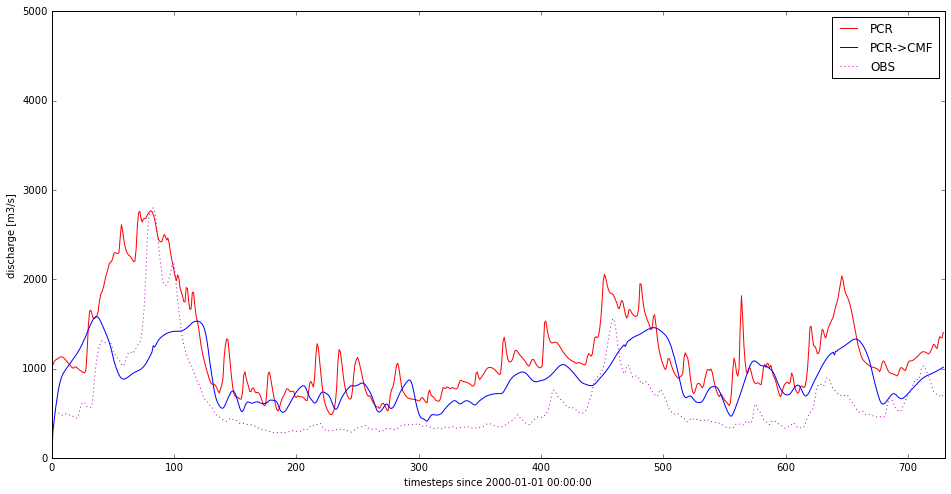

In [18]:
plt.figure(figsize=(16,8))
plt.plot(PCR_ND, 'r',label = 'PCR')
plt.plot(cd, 'b', label = 'PCR->CMF')
plt.plot(qobs_ND, ':', c='m', label = 'OBS')
plt.legend(loc=1)
plt.xlim(0, minLength)
plt.ylim(0, 5000)
plt.ylabel('discharge [m3/s]')
plt.xlabel('timesteps since '+str(start_date))

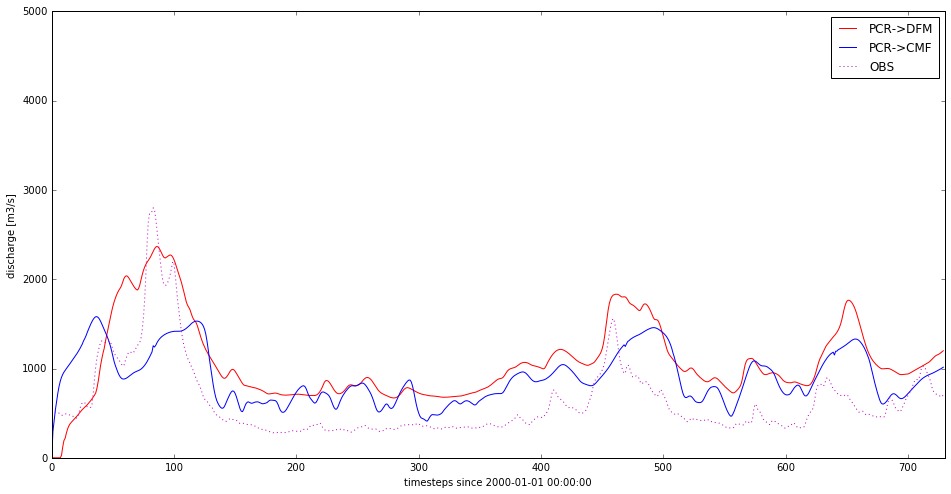

In [19]:
plt.figure(figsize=(16,8))
plt.plot(qsim_ND_1way, 'r',label = 'PCR->DFM')
plt.plot(cd, 'b', label = 'PCR->CMF')
plt.plot(qobs_ND, ':', c='m', label = 'OBS')
plt.legend(loc=1)
plt.xlim(0, minLength)
plt.ylim(0, 5000)
plt.ylabel('discharge [m3/s]')
plt.xlabel('timesteps since '+str(start_date))